# Лабораторная работа 5. Восстановление плотности вероятности

## Генерация данных

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt

from typing import Mapping

Функция для генерации рандомных точек с нормальным распределением

In [2]:
def gen_normal(mu, sigma, count):
    s = np.random.normal(mu, sigma, size=(2, count))
    return s

In [3]:
normal_points = gen_normal(0, 0.1, 1000)

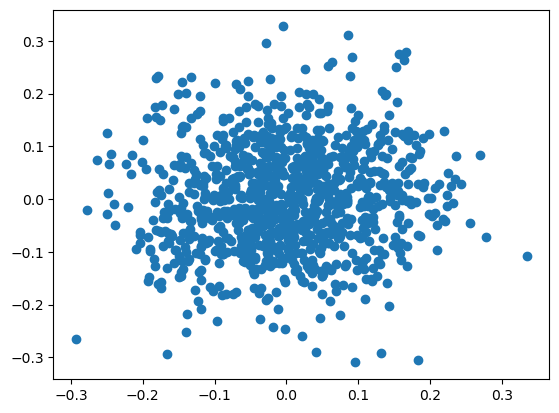

In [4]:
plt.scatter(normal_points[0], normal_points[1])
plt.show()

Функция для генерации рандомных точек с равномерным распределением

In [5]:
def gen_uniform(count):
    low, high = -0.2, 0.2
    s = np.random.uniform(low, high, size=(2, count))
    return s

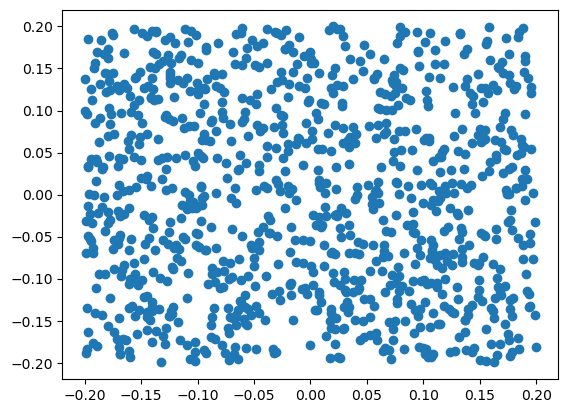

In [6]:
uniform_points = gen_uniform(1000)
plt.scatter(uniform_points[0], uniform_points[1])
plt.show()

Функция для генерации рандомных точек с распределением два пика

In [259]:
def gen_two_peaks(count):
    n1 = gen_normal(-10, 1, count // 2)
    n2 = gen_normal(50, 50, count // 2)
    return n1 + n2

In [260]:
two_peaks_points = gen_two_peaks(1000)

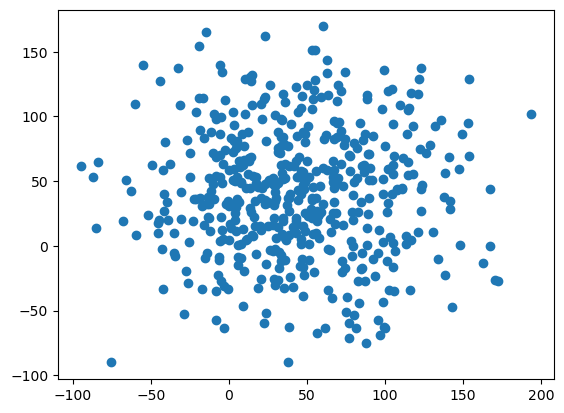

In [261]:
plt.scatter(two_peaks_points[0], two_peaks_points[1])
plt.show()

In [250]:
def parse_points(data):
    points_list = []
    for i in range(len(data[0])):
        points_list.append((data[0][i], data[1][i]))
    return points_list

## Метод Парсена-Разенблатта (метод окна)

### Оценка Парзена плотности для каждого класса y

$ p(x|y) = \frac{1}{l_yV(h)}\sum\limits_{i: y = y_i} K\left(\frac{\rho(x,x_i)}{h}\right)$

### Метод парзеновского окна

$ a(x; X^l, h) = \underset{y \in Y}{\arg \max}\lambda_y \frac{P(y)}{l_y} \sum\limits_{i: y = y_i} K\left(\frac{\rho(x,x_i)}{h}\right)$

### Параметры

$\rho(x,x_i)$ - функция расстояния

l - размерность

h - окно

K(r) - ядро
- четная функция
- нормированная $\int K(r)dr = 1$
- невозрастающая при r > 0
- неотрицательная

In [10]:
#функция расстояния
def euclid_dist(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [24]:
#Гауссово ядро
def gauss_kernel(x):
    return ((2 * math.pi) ** (-1/2)) * np.exp(-1/2 * (x ** 2))

In [57]:
def parzen_score(x, data, h, K: Mapping, dist_function: Mapping):
    k_sum = 0
    for point in data:
        k_sum += K(dist_function(x, point) / h)
    return k_sum / (len(data) * h)

### Восстановим для нормального распределения

In [221]:
X, Y = np.mgrid[-15:15:21j, -15:15:21j]
xy = np.vstack((X.flatten(), Y.flatten())).T

result_data = [parzen_score(p, parse_points(normal_points), 5, gauss_kernel, euclid_dist) for p in xy]

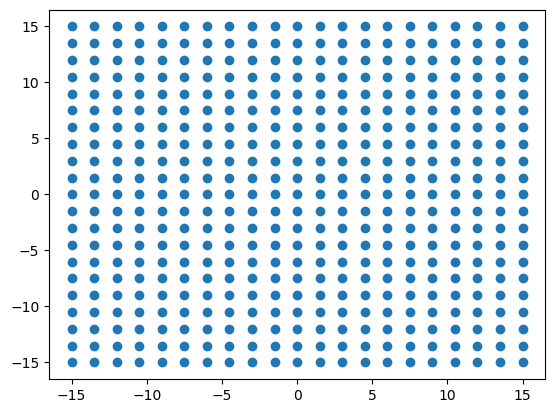

In [222]:
all_x = [p[0] for p in xy]
all_y = [p[1] for p in xy]
plt.scatter(all_x, all_y)

In [223]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

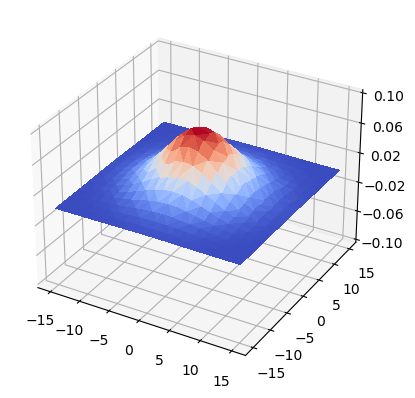

In [224]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.1, 0.1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

### Восстановим для равномерного

In [219]:
result_data = [parzen_score(p, parse_points(uniform_points), 5, gauss_kernel, euclid_dist) for p in xy]

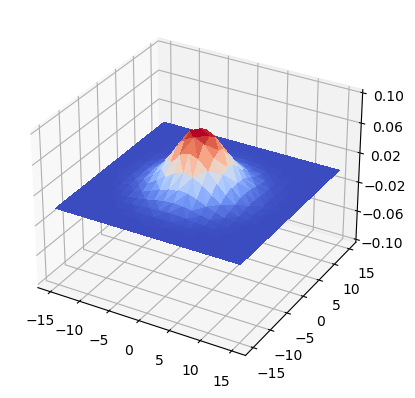

In [220]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.1, 0.1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

Не получилось с помощью Гауссова ядра, попробуем прямоугольное

In [27]:
#Прямоугольное ядро

def rect_kernel(x):
    if abs(x) <= 1:
        return 1
    return 0

In [64]:
result_data = [parzen_score(p, parse_points(uniform_points), 10, rect_kernel, euclid_dist) for p in xy]

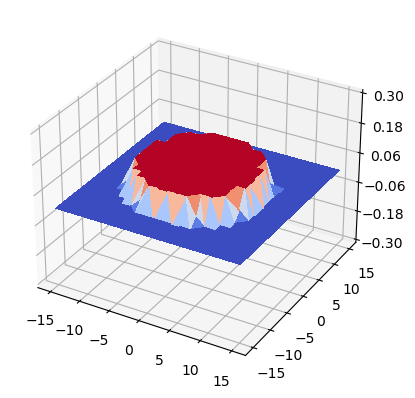

In [65]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.3, 0.3)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

### Восстановим для два пика

In [262]:
X, Y = np.mgrid[-20:20:21j, -20:20:21j]
xy = np.vstack((X.flatten(), Y.flatten())).T

result_data = [parzen_score(p, parse_points(two_peaks_points), 4, gauss_kernel, euclid_dist) for p in xy]

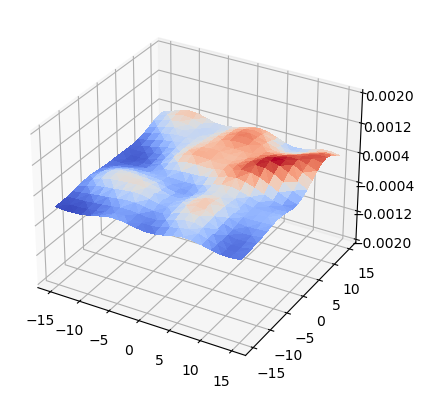

In [264]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-2e-3, 2e-3)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

Не получилось

## Оптимизация ширины окна методом LOO

$ LOO(h, X^l) = -\sum\limits_{i = 1}^{l} \left[\ln {p_h}\left(x_i;\frac{X^l}{x_i}, h \right) \neq y_i\right] \rightarrow \underset{h}{\min}$

In [105]:
def leave_one_out(h, data, kernel_function: Mapping, dist_function: Mapping):
    loo = 0
    for i in range(len(data)):
        loo += math.log(parzen_score(data[i], data[:i] + data[i+1:], h, kernel_function, dist_function))
    return -loo

In [226]:
h_list = np.arange(0.1, 20, 0.5)
min_h = 0.1
min_h_val = 1e8

for h in h_list:
    tmp = leave_one_out(h, parse_points(normal_points), gauss_kernel, euclid_dist)
    if tmp < min_h_val:
        min_h_val = tmp
        min_h = h
print(h)

19.6


In [227]:
X, Y = np.mgrid[-20:20:21j, -20:20:21j]
xy = np.vstack((X.flatten(), Y.flatten())).T

result_data = [parzen_score(p, parse_points(normal_points), 20, gauss_kernel, euclid_dist) for p in xy]

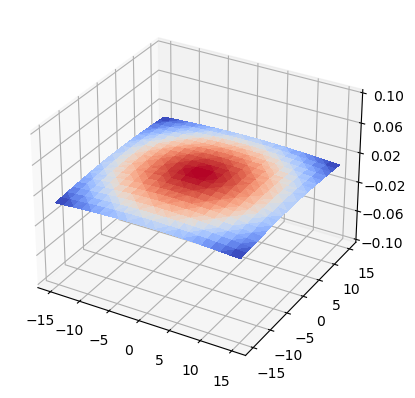

In [228]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-0.1, 0.1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

## EM-алгоритм

In [265]:
from sklearn.mixture import GaussianMixture

In [266]:
gm = GaussianMixture(n_components=2, random_state=0).fit(parse_points(two_peaks_points))
gm.means_

array([[78.17475048, 40.28201308],
       [13.08482775, 41.8701251 ]])

In [268]:
X, Y = np.mgrid[-40:40:21j, -40:40:21j]
xy = np.vstack((X.flatten(), Y.flatten())).T

result_data = gm.predict_proba(xy)

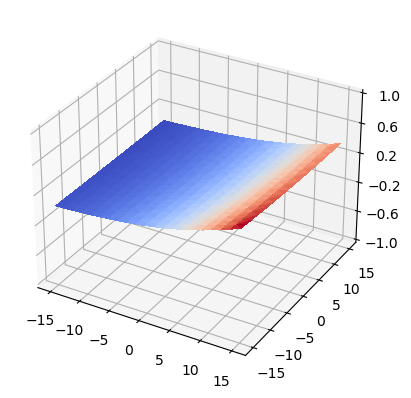

In [272]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data[:,0]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()

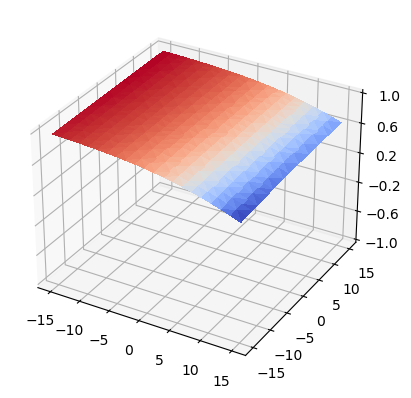

In [273]:
ax = plt.figure().add_subplot(projection='3d')
surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(result_data[:,1]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(6))

plt.show()